Get data

In [5]:
import pandas as pd
from helpers.data_preprocessing import DataProcesser

from helpers.data_loader import DataLoader
from helpers.data_preprocessing import DataProcesser

def load_comments():
    code = DataLoader.load_csv_file("./../../data/code_data.csv", ['code'])

    def load_longer_code():
        f = open("./../../data/code.txt", "r")
        Lines = f.readlines()
        code_long = []
        for line in Lines:
            line = line.rstrip()
            # print(line)
            code_long.append(line)
        f.close()
        return code_long

    code_long = load_longer_code()
    for index, row in code.iterrows():
        curr_code_long = code_long[index]
        if curr_code_long != '':
            row['code'] = curr_code_long
    return code
code = load_comments()
code.head()

df = pd.read_csv("./../../data/train_set_0520.csv", usecols=['comment', 'non-information'])
df['code'] = code['code']
df.head()

,comment,non-information,code
0,@implNote taken from {@link com.sun.javafx.sce...,yes,"""public static void showContextMenu(TextArea t..."
1,icon.setToolTipText(printedViewModel.getLocali...,yes,"TABLE_ICONS.put(SpecialField.PRINTED, icon);"
2,Synchronize changes of the underlying date val...,no,BindingsHelper.bindBidirectional(valueProperty...
3,Ask if the user really wants to close the give...,yes,"""private boolean confirmClose(BasePanel panel)..."
4,css: information *,no,"INTEGRITY_INFO(MaterialDesignIcon.INFORMATION),"


Preprocess comments and code
1. Separate words from camel case and snake case,
2. To lower case,
3. Remove java tags and keywords,
4. remove accented chars,
5. stem

In [8]:
df['comment'] = df['comment'].apply(str)
df['comment'] = df['comment'].apply(DataProcesser.extract_camel_case)
df['comment'] = df['comment'].apply(DataProcesser.remove_stopwords)
df['comment'] = df['comment'].apply(DataProcesser.extract_snake_case)
df['comment'] = df['comment'].apply(DataProcesser.preprocess)

df['code'] = df['code'].apply(str)
df['code'] = df['code'].apply(DataProcesser.extract_camel_case)
df['code'] = df['code'].apply(DataProcesser.extract_snake_case)
df['code'] = df['code'].apply(DataProcesser.remove_java_keywords)
df['code'] = df['code'].apply(DataProcesser.preprocess_code)
df['code'] = df['code'].apply(DataProcesser.remove_stopwords)

df.head()

,comment,non-information,code
0,impl note taken link com sun javafx scene cont...,yes,show context menu text area text area context ...
1,icon set tool tip text pred view model get local,yes,tabl icon put special field pred icon
2,synchron chang underli date valu tempor access...,no,bind helper bind bidirect valu properti tempor...
3,ask user realli want close given databas,yes,confirm close base panel panel filenam panel g...
4,css inmat,no,egriti info materi design icon inmat


Count common words between code and comments

In [9]:
from helpers.textual_analysis import *
from helpers.text_similarity import TextSimilarity

df['word_counts'] = df.apply(lambda row: count_common_words(row['comment'], row['code']), axis=1)
df['jaccard_score'] = df.apply(lambda row: TextSimilarity.get_similarity_score(
            s1=row['comment'],
            s2=row['code'],
            type='JACC'), axis=1)
df['cosine_score'] = df.apply(lambda row: TextSimilarity.get_similarity_score(
            s1=row['comment'],
            s2=row['code'],
            type='COSINE_TFIDF'), axis=1)
df.head()


,comment,non-information,code,word_counts,jaccard_score,cosine_score
0,impl note taken link com sun javafx scene cont...,yes,show context menu text area text area context ...,0.036810,0.018750,1.267550
1,icon set tool tip text pred view model get local,yes,tabl icon put special field pred icon,0.235294,0.133333,0.457809
2,synchron chang underli date valu tempor access...,no,bind helper bind bidirect valu properti tempor...,0.352941,0.214286,0.744121
3,ask user realli want close given databas,yes,confirm close base panel panel filenam panel g...,0.044199,0.022599,0.432192
4,css inmat,no,egriti info materi design icon inmat,0.250000,0.142857,0.225480


Average of counts of common words between code and comments for non-information: yes

In [17]:
from helpers.textual_analysis import *

bad_comments = df[df['non-information'] == 'yes']
bad_comments['cosine_score'].mean()

0.16925471917458418

Average of counts of common words between code and comments for non-information: yes

0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


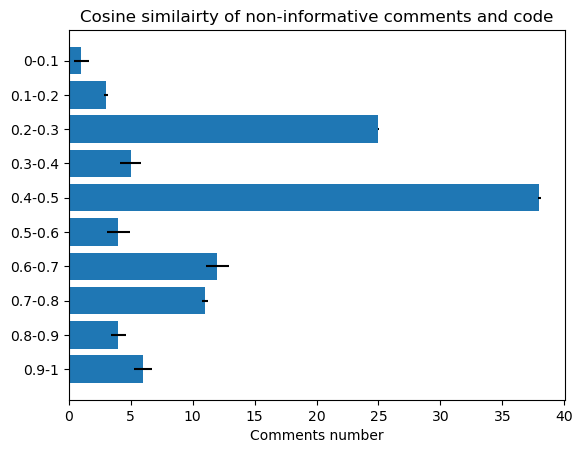

In [18]:
arr = []
for i in range(1, 11):
    comments_smaller = bad_comments[bad_comments['cosine_score'] < 0.1 * i]
    print(i*0.1)
    num = comments_smaller[comments_smaller['cosine_score'] > (0.1 * i - 0.1)].shape[0]
    arr.append(num)

import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = ('0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1')
y_pos =  np.arange(len(people))
performance = np.array(arr)
error = np.random.rand(len(people))

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Comments number')
ax.set_title('Cosine similairty of non-informative comments and code')

plt.show()

Average of counts of common words between code and comments for non-information: no

In [19]:
from helpers.textual_analysis import *

bad_comments = df[df['non-information'] == 'no']
bad_comments['cosine_score'].mean()

0.38784936061098424

Average of counts of common words between code and comments for non-information: yes

0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
[5, 16, 89, 16, 54, 20, 35, 45, 23, 30]
[5, 16, 89, 16, 54, 20, 35, 45, 23, 30]


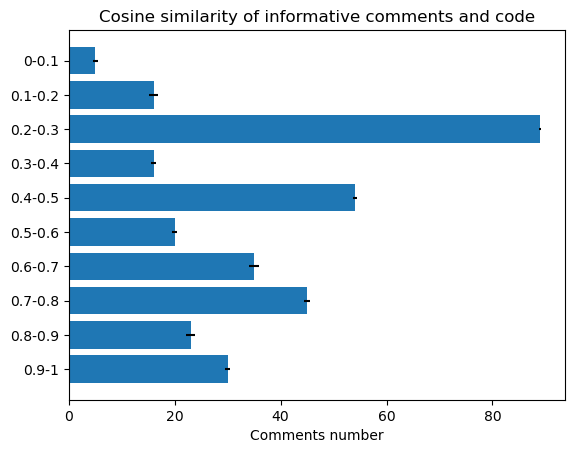

In [21]:
arr = []
for i in range(1, 11):
    comments_smaller = bad_comments[bad_comments['cosine_score'] < 0.1 * i]
    print(i*0.1)
    num = comments_smaller[comments_smaller['cosine_score'] > (0.1 * i - 0.1)].shape[0]
    arr.append(num)
print(arr)
print(arr)
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = ('0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1')
y_pos =  np.arange(len(people))
performance = np.array(arr)
error = np.random.rand(len(people))

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Comments number')
ax.set_title('Cosine similarity of informative comments and code')

plt.show()

Median of counts of common words between code and comments for non-information: yes

In [21]:
from helpers.textual_analysis import *

bad_comments = df[df['non-information'] == 'yes']
bad_comments['cosine_score'].median()


0.0

Average of counts of common words between code and comments for non-information: no

In [22]:
from helpers.textual_analysis import *

bad_comments = df[df['non-information'] == 'no']
bad_comments['cosine_score'].median()

0.05903010462568318

Average of counts of common words between code and comments for non-information: yes

In [23]:
from helpers.textual_analysis import *

bad_comments = df[df['non-information'] == 'yes']
bad_comments = bad_comments[bad_comments['cosine_score'] != 0]
bad_comments['cosine_score'].mean()


0.5445586616921404

Average of counts of common words between code and comments for non-information: no

In [ ]:
from helpers.textual_analysis import *

good_comments = df[df['non-information'] == 'no']
good_comments = good_comments[good_comments['cosine_score'] != 0]
good_comments['cosine_score'].mean()

The number of no common words- between comment and code for non-information: yes

In [ ]:
from helpers.textual_analysis import *

bad_comments = df[df['non-information'] == 'yes']
bad_comments_num = bad_comments.count()
bad_comments = bad_comments[bad_comments['cosine_score'] == 0]
bad_comments.count()/bad_comments_num

The number of no common words- between comment and code  for non-information: no

In [ ]:
from helpers.textual_analysis import *

good_comments = df[df['non-information'] == 'no']
good_comments_num = good_comments.count()
good_comments = good_comments[good_comments['cosine_score'] == 0]
good_comments.count()/good_comments_num


